In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

# Normalization Techniques

Within the literature, the typical solution to oversmoothing is to apply some type of normalization. To this end, we propose orthogonalizing out vector $\vec{q}$ (essentially a "best guess" for $v_{1}$) from $X^{l}$ and then renormalizing each column. We incorporate additional scale parameters $0\leq{}s_{1}\leq{}1$ and $s_{2}$.

$$X_{i}^{l} = X_{i}^{l} - s_{1}\frac{X_{i}^{l}\cdot{}\vec{q}}{||\vec{q}||_{2}^{2}}\vec{q}$$
$$X_{i}^{l} = s_{2}\frac{X_{i}^{l}}{||X_{i}^{l}||_{2}}$$

If $s_{1}=1$ and $\vec{q}=\vec{1}$, this is equivalent to PairNorm [16]. Define the smoothness of feature $i$ at GCN layer $l$ as

$$S = \frac{1}{E[X^{l} - E[X^{l}]]}$$

PairNorm aims to minimize global smoothness by subtracting out the mean feature vector and renormalizing. 

$$X_{i}^{l} = X_{i}^{l} - E[X_{i}^{l}]$$
$$X_{i}^{l} = s \frac{X_{i}^{l}}{||X_{i}^{l}||_{2}}$$

We evaluate our normalization scheme with $\vec{q} = \frac{1}{\vec{d}_{degree}}$ and compare against both PairNorm and GraphSizeNorm [3].

## Dataset

In [2]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

## Model

In [3]:
def batched_MAP(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1)
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

In [4]:
class OrthNormL2(torch.nn.Module):
    def __init__(self):
        super(OrthNormL2,self).__init__()
        self.s1 = torch.nn.Parameter(torch.ones(1))
        self.s2 = torch.nn.Parameter(torch.ones(1))

    def forward(self,X,edge_index,edge_weight,batch):
        n = 1/torch_geometric.utils.degree(edge_index[0])
        n_norm = torch_scatter.scatter_sum(n**2,batch,dim=0)
        
        alpha = torch_scatter.scatter_sum(X * n[:,None],batch,dim=0)/(n_norm)[:,None]
        
        X = X - torch.sigmoid(self.s1) * (alpha)[batch] * n[batch][:,None]
        X = self.s2 * X/(torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt())[batch]
        return X

In [5]:
class DummyModel(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth,norm,p=2):
        super(DummyModel,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.norm = torch.nn.ModuleList([norm() for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)

    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        for idx,m in enumerate(self.intermediate):
            X = X + m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(self.norm[idx](X,edge_index,edge_weight,batch))
            if torch.isnan(X).any(): raise ValueError
        return self.finish(X)

## OrthNorm

In [6]:
graph_results = []
model_mad = []

torch.manual_seed(0)
for k in [2,4,8,16,32,64]:
    torch.manual_seed(0)
    graph = DummyModel(1,32,1,k,OrthNormL2).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

    MAD = torch.zeros(k+1)
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        MAD[0] += batched_MAP(X,edge_index,edge_weight).mean().item()

        for jdx,m in enumerate(graph.intermediate):
            X = X + m[0](X) + torch_scatter.scatter_sum(m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(graph.norm[jdx](X,edge_index,edge_weight,batch))
            MAD[jdx+1] += batched_MAP(X,edge_index,edge_weight).mean().item()

    model_mad.append(MAD/(idx+1))

### Results

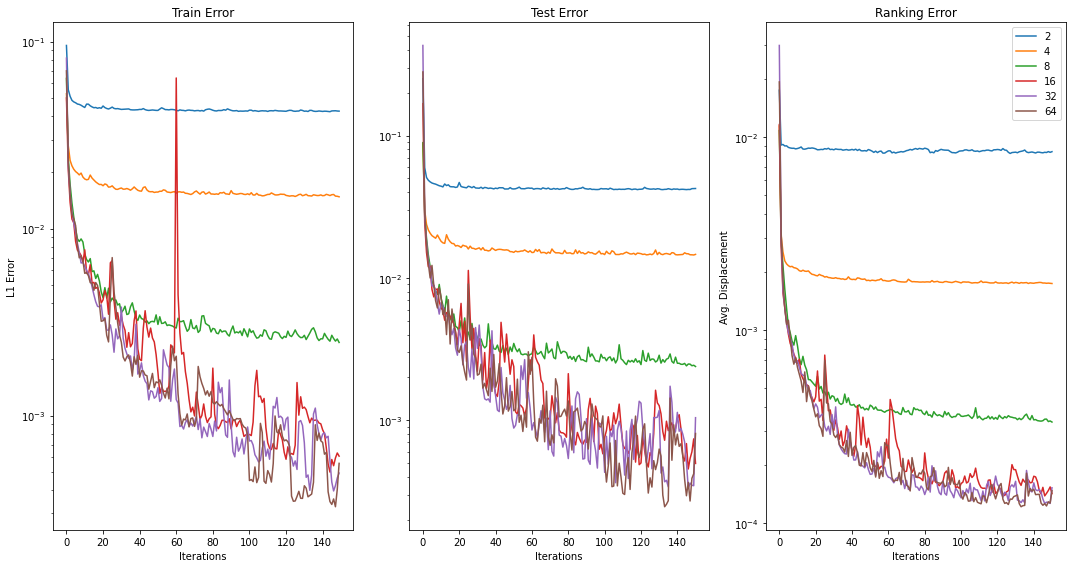

In [7]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(6):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(6):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

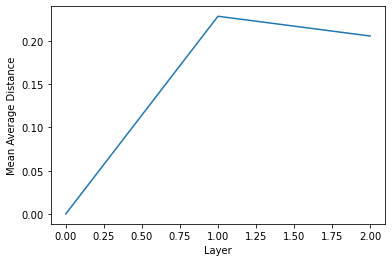

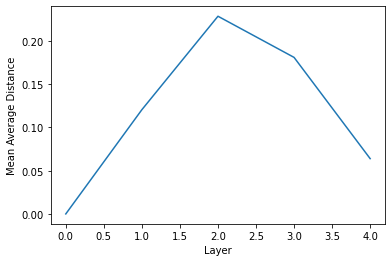

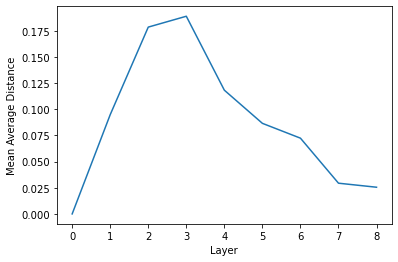

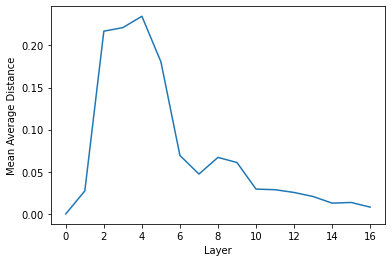

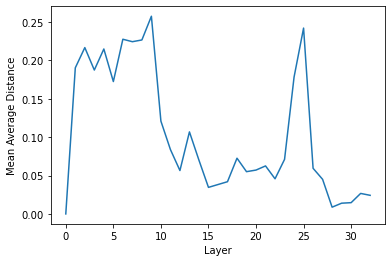

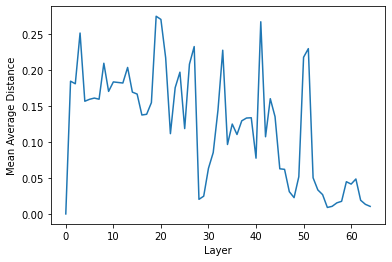

In [8]:
for idx,d in enumerate(model_mad):
  plt.plot(d,label='GraphConv')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')
  plt.show()

## GraphSizeNorm

In [9]:
class GraphSizeNorm(torch.nn.Module):
    def __init__(self):
        super(GraphSizeNorm,self).__init__()
        self.norm = torch_geometric.nn.GraphSizeNorm()
    def forward(self,X,edge_index,edge_weight,batch):
        return self.norm(X,batch)

In [10]:
graph_results = []
model_mad = []

torch.manual_seed(0)
for k in tqdm([2,4,8,16,32,64]):
    torch.manual_seed(0)

    graph = DummyModel(1,32,1,k,GraphSizeNorm).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

    MAD = torch.zeros(k+1)
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        MAD[0] += batched_MAP(X,edge_index,edge_weight).mean().item()

        for jdx,m in enumerate(graph.intermediate):
            X = X + m[0](X) + torch_scatter.scatter_sum(m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(graph.norm[jdx](X,edge_index,edge_weight,batch))
            MAD[jdx+1] += batched_MAP(X,edge_index,edge_weight).mean().item()
        
    model_mad.append(MAD/(idx+1))

100%|██████████| 6/6 [32:16<00:00, 322.78s/it]


### Results

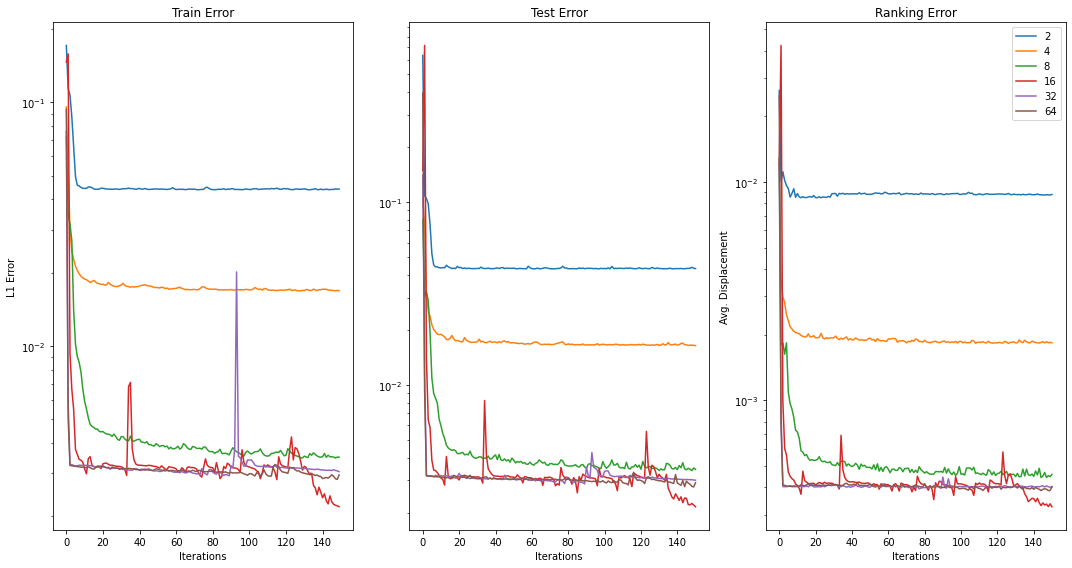

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(6):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(6):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

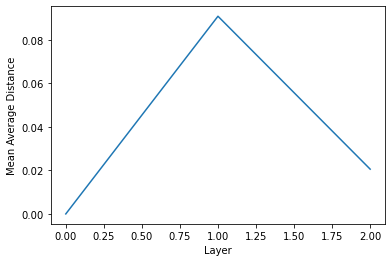

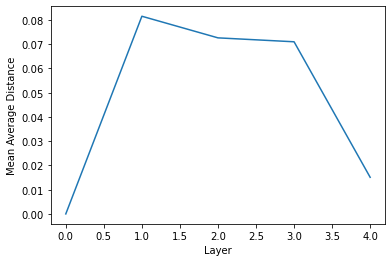

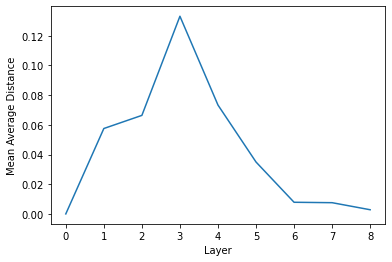

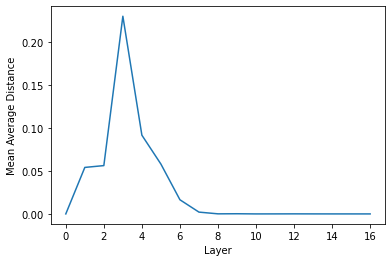

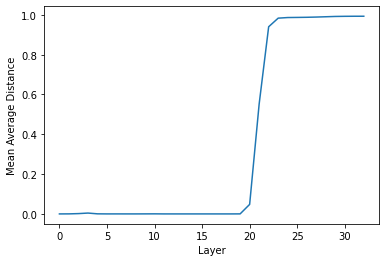

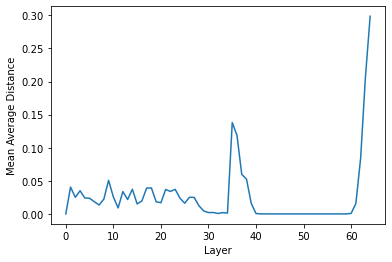

In [12]:
for idx,d in enumerate(model_mad):
  plt.plot(d,label='GraphConv')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')
  plt.show()

## PairNorm

In [13]:
class PairNorm(torch.nn.Module):
    def __init__(self):
        super(PairNorm,self).__init__()
        self.norm = torch_geometric.nn.PairNorm(scale_individually=True)
    def forward(self,X,edge_index,edge_weight,batch):
        return self.norm(X,batch)

In [14]:
graph_results = []
model_mad = []

for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    graph = DummyModel(1,32,1,k,PairNorm).cuda()
    
    graph_results.append(train_loop(graph,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

    MAD = torch.zeros(k+1)
    for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        graph.eval()
        X = graph.start(X)
        MAD[0] += batched_MAP(X,edge_index,edge_weight).mean().item()

        for jdx,m in enumerate(graph.intermediate):
            X = X + m[0](X) + torch_scatter.scatter_sum(m[1](X)[edge_index[1]], edge_index[0],dim=0)
            X = torch.nn.LeakyReLU()(graph.norm[jdx](X,edge_index,edge_weight,batch))
            MAD[jdx+1] += batched_MAP(X,edge_index,edge_weight).mean().item()

        
    model_mad.append(MAD/(idx+1))

### Results

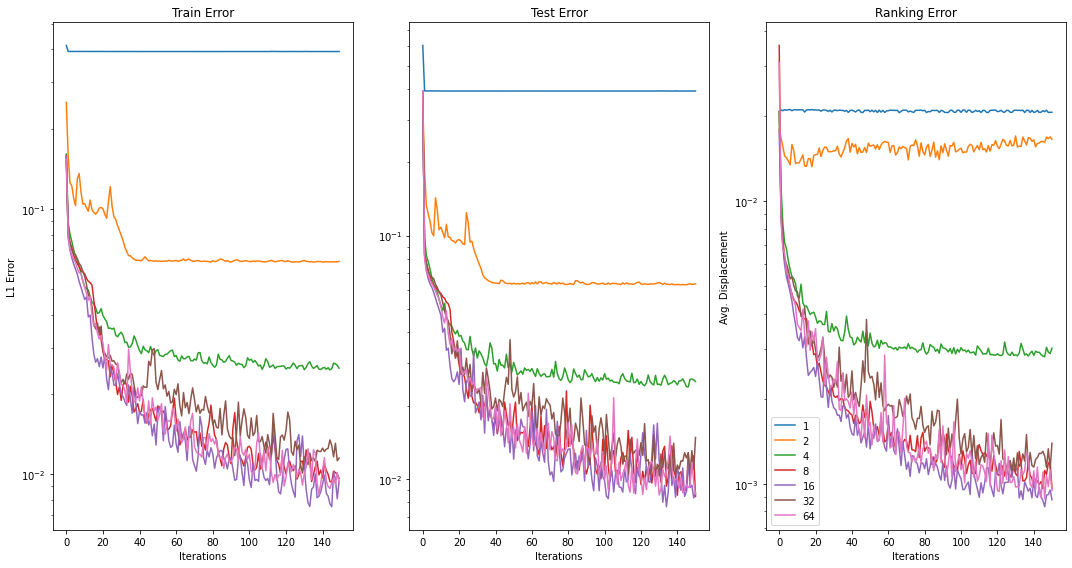

In [15]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

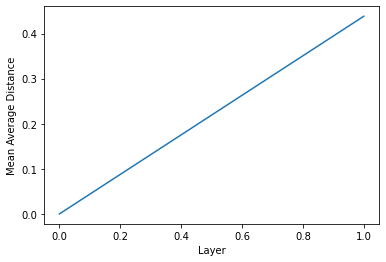

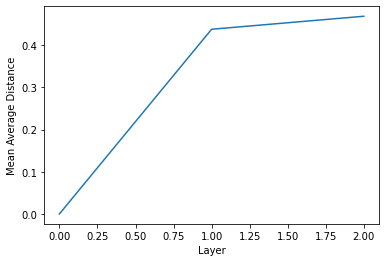

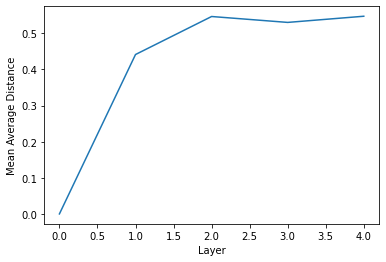

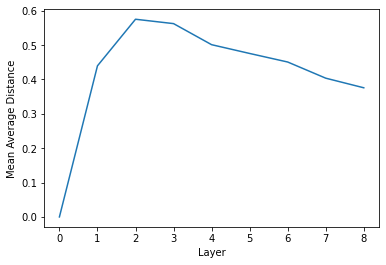

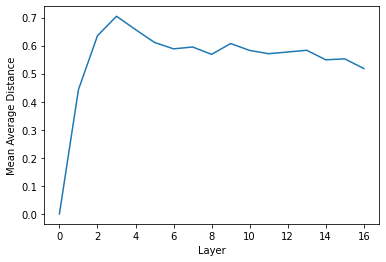

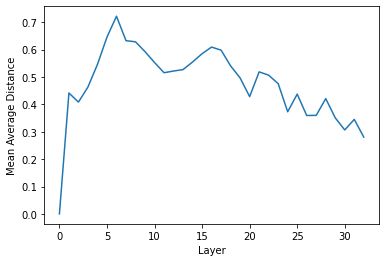

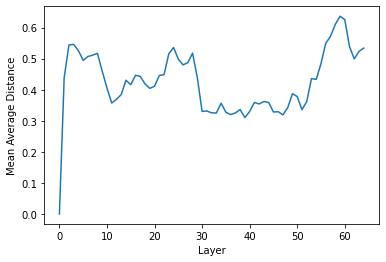

In [16]:
for idx,d in enumerate(model_mad):
  plt.plot(d,label='GraphConv')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')
  plt.show()

## Overview

Our new normalization scheme, which we are calling OrthNorm (i.e Orthagonal Normalization, get it?), improves upon the unnormalized case, even without having fully converged. It surpasses PairNorm by around an order of magnitude given the same depth and number of epochs. We suspect this is because $d_{Katz}$ is close enough to $v_{1}$, and so PairNorm reduces the smoothness *too* much. Indeed, PairNorm returns uniformly large MAP values, whereas those of OrthNorm are generally smaller and more erratic. This is due to $s_{1}$ regulating the magnitude of the orthogonalization; without it, MAP consistently hovers around $.20$, and the loss is about $1e^{-3}$ larger. 

As for GraphSizeNorm, there is certainly some benefit, but it does still converge to a larger value than OrthNorm (which isn't even convergent yet). Oddly enough, while the MAP is otherwise quite low, GraphSizeNorm spikes in the last few layers for both the $l=32$ and $l=64$ models. We do not have an explanation for why this occurs.